## Liabrary imports

In [ ]:
import os

# Establishing the current work directory (cwd)
thisdir = "provide your data location"  # PATH where database recordings are saved
Files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".txt" in file:
            Files.append(os.path.join(r, file))
filenames = Files


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import pywt
from scipy import stats
from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline 


## Initials

In [ ]:
# Set global seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

seedList = [1, 5, 42, 100, 123]  # List of seeds for reproducibility and robustness


In [ ]:
# ============================
# CONFIGURATION PARAMETERS
# ============================
END_POINT = 2000
SEGMENT_LENGTH = 100    # Use first 100 samples of each gesture
FS = 1000              # Sampling frequency (Hz)
THRESHOLD = 0.01       # Threshold for Willison amplitude

# Parameters for filtering
fs = 1000.0
low = 10.0
high = 400.0
order = 5
f0_notch = 50.0
Q_notch = 50.0


## Functions

### Total Data Acquisition

In [428]:
def softThreshDWT(signal, wavelet='db4', level=4, T_mult=1.0):
    """
    DWT-based soft thresholding denoiser (EMG-friendly)

    Parameters
    ----------
    signal : 1D array
        Noisy EMG signal
    wavelet : str
        Wavelet name (e.g., 'db4', 'sym4')
    level : int
        Decomposition level
    T_mult : float
        Threshold multiplier

    Returns
    -------
    denoised_signal : ndarray
    c_before : list
        Wavelet coefficients before thresholding
    """

    x = np.asarray(signal, dtype=float)
    n = len(x)

    # Wavelet decomposition
    coeffs = pywt.wavedec(x, wavelet, level=level, axis=0)
    c_before = [c.copy() for c in coeffs]

    # coeffs = [cA_n, cD_n, cD_{n-1}, ..., cD1]
    cD1 = coeffs[-1]

    # Noise estimation (MAD)
    sigma = np.median(np.abs(cD1)) / 0.6745
    threshold = T_mult * sigma * np.sqrt(2 * np.log(n))

    # Soft thresholding ONLY detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = np.sign(coeffs[i]) * np.maximum(
            np.abs(coeffs[i]) - threshold, 0.0
        )

    # Reconstruction
    denoised_signal = pywt.waverec(coeffs, wavelet, axis=0)
    denoised_signal = denoised_signal[:n]

    return denoised_signal


In [429]:
def bandpass_emg(x, fs=fs, low=low, high=high, order=order):
    """
    Zero-phase Butterworth band-pass for multi-channel EMG.
    x shape: (n_samples, n_channels), time on axis=0.
    """
    nyq = fs / 2.0
    if high >= nyq:
        high = 0.99 * nyq  # nudge inside Nyquist if needed
    if not (0 < low < high < nyq):
        raise ValueError(f"Cutoffs must satisfy 0 < {low} < {high} < Nyquist ({nyq} Hz).")

    wn = [low / nyq, high / nyq]
    sos = butter(order, wn, btype="bandpass", output="sos")
    return sosfiltfilt(sos, x, axis=0)


In [430]:
def notch_filter(x, fs=fs, f0=f0_notch, Q=Q_notch):
    """
    Narrow 50 Hz notch to reduce mains hum (adjust Q as needed).
    """
    w0 = f0 / (fs / 2.0)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, x, axis=0)


In [431]:
def Data_separation(filename, end_point, segment_length, initializer=True):
    """
    Load a tab-separated EMG recording and return per-gesture slices.

    The function reads a file (TSV), drops a 'time' column if present, and
    extracts a fixed-length slice for each gesture class labeled 1..6.

    Parameters
    ----------
    filename : str
        Path to the TSV file containing EMG data. The file must contain a
        'class' column with integer labels (1..6) and optionally a 'time' column.
    end_point : int
        End index (sample) for slicing. Slicing uses Python indexing and is
        interpreted as sample indices (not milliseconds).
    segment_length : int
        Length of the segment to extract (in samples). When initializer is
        False the start is set to (end_point - segment_length), otherwise start
        is 0.
    initializer : bool, optional
        If True, slices start at 0 and end at end_point. If False, slices start
        at end_point - segment_length and end at end_point. Default True.

    Returns
    -------
    list of pandas.DataFrame
        List [df1, df2, df3, df4, df5, df6] where each dfi is the sliced DataFrame
        containing rows for class==i within the selected index range. If a class
        is not present in the file the corresponding DataFrame will be empty.

    Notes
    -----
    - The function assumes the file is tab-separated and that the 'class' column
      contains integer labels 1 through 6.
    - Any errors reading the file or missing columns will raise the corresponding
      pandas exception.
    """
    Data = pd.read_csv(filename, sep="\t").drop(columns="time")

    #  Separate the data into different classes based on had gesture labels [1 to 6]

    cut_point = end_point  # Define the cut point for each class
    if initializer:
        start_point = 0
    else:
        start_point = cut_point - segment_length  # Define the start point for each class

    df1 = Data[Data['class'] == 1][start_point:cut_point]
    df2 = Data[Data['class'] == 2][start_point:cut_point]
    df3 = Data[Data['class'] == 3][start_point:cut_point]
    df4 = Data[Data['class'] == 4][start_point:cut_point]
    df5 = Data[Data['class'] == 5][start_point:cut_point]
    df6 = Data[Data['class'] == 6][start_point:cut_point]

    return [df1, df2, df3, df4, df5, df6]           # Return a list of the separated dataframes


In [432]:
def load_data(filenames, end_point, segment_length, initializer=True):
    """
    Load and aggregate gesture data from multiple files.

    For each file in `filenames` this function calls `Data_separation(...)`
    to obtain six per-gesture DataFrames (classes 1..6). It then concatenates
    all recordings for each gesture across files and finally concatenates the
    six gesture DataFrames into a single DataFrame.

    Parameters
    ----------
    filenames : list of str
        Paths to tab-separated EMG recording files. Each file is processed by
        `Data_separation` which is expected to return a list of six DataFrames
        corresponding to gesture classes 1..6.
    end_point : int
        End index (sample) passed to `Data_separation`.
    segment_length : int
        Segment length (samples) passed to `Data_separation`.
    initializer : bool, optional
        Passed through to `Data_separation`. If True slices start at 0, else
        slices are taken from (end_point - segment_length) to end_point.
        Default is True.

    Returns
    -------
    pandas.DataFrame
        Single DataFrame containing all concatenated gesture rows (classes 1..6),
        preserving original columns from the source files. If `filenames` is an
        empty list this returns an empty DataFrame (may raise if pd.concat is
        called on empty lists in other runtime states).

    Notes
    -----
    - This function relies on `Data_separation` being defined in the notebook.
    - Any exceptions raised by `Data_separation` or `pd.concat` (e.g. missing
      expected columns) will be propagated to the caller.
    """
    gesto_lst_1, gesto_lst_2, gesto_lst_3, gesto_lst_4, gesto_lst_5, gesto_lst_6 = [],[],[],[],[],[]
    for file in filenames:
        [df1,df2,df3,df4,df5,df6] = Data_separation(file, end_point, segment_length, initializer=initializer)
        gesto_lst_1.append(df1)
        gesto_lst_2.append(df2)
        gesto_lst_3.append(df3)
        gesto_lst_4.append(df4)
        gesto_lst_5.append(df5)
        gesto_lst_6.append(df6)
        
    Gesto1 = pd.concat(gesto_lst_1, ignore_index=True)
    Gesto2 = pd.concat(gesto_lst_2, ignore_index=True)
    Gesto3 = pd.concat(gesto_lst_3, ignore_index=True)
    Gesto4 = pd.concat(gesto_lst_4, ignore_index=True)
    Gesto5 = pd.concat(gesto_lst_5, ignore_index=True)
    Gesto6 = pd.concat(gesto_lst_6, ignore_index=True)

    data = pd.concat([Gesto1, Gesto2, Gesto3, Gesto4, Gesto5, Gesto6], ignore_index=True)

    return data


### Other Corresponding Functions

In [ ]:
# ============================
# SEGMENT EXTRACTION
# ============================


def extract_segments_from_dataframe(data, fs = fs, dwt_filt = False, apply_filter=False, low = low, high = high, order = order,
                                    notch_filt = False, notch_Q = Q_notch, segment_length=SEGMENT_LENGTH):
    """
    Extract segments of a specified length from a single dataframe
    Assumes the dataframe contains data for a single gesture class
    Returns:
    - segments: list of (segment_length, n_channels) numpy arrays
    - labels: list of gesture labels (all the same for this dataframe)
    """

    signals = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values.astype(int)

    if apply_filter:
        signals = bandpass_emg(signals, fs=fs, low=low, high=high, order=order)
    if notch_filt:
        signals = notch_filter(signals, fs=fs, f0=f0_notch, Q=notch_Q)
    if dwt_filt:
        signals = softThreshDWT(signals)

    segments = []
    segment_labels = []

    # Extract multiple non-overlapping segments of segment_length
    n_samples = signals.shape[0]
    step_size = segment_length # Use non-overlapping segments

    for start in range(0, n_samples - segment_length + 1, step_size):
        end = start + segment_length
        segment = signals[start:end, :]
        segments.append(segment)
        segment_labels.append(labels[start]) # All segments from this df have the same label

    return segments, segment_labels


In [ ]:
# ============================
# FEATURE EXTRACTION
# ============================
def extract_features_from_segment(segment):
    """
    Extract features from a single gesture segment (200 samples)
    Returns: 1D feature vector containing features for all channels
    """
    feature_vector = []
    n_channels = segment.shape[1]

    for ch in range(n_channels):
        channel_data = segment[:, ch]

        # ----------------------------
        # TIME-DOMAIN FEATURES
        # ----------------------------
        # 1. Mean Absolute Value (MAV) - initial activation level
        mav = np.mean(np.abs(channel_data))

        # 2. Variance (VAR) - initial signal variability
        var = np.var(channel_data)

        # 3. Root Mean Square (RMS) - initial contraction intensity
        rms = np.sqrt(np.mean(channel_data**2))

        # 4. Zero Crossings (ZC) - initial frequency content
        zc = np.sum(np.diff(np.sign(channel_data)) != 0)

        # 5. Slope Sign Changes (SSC) - initial complexity
        ssc = np.sum(np.diff(np.sign(np.diff(channel_data))) != 0)

        # 6. Waveform Length (WL) - cumulative initial change
        wl = np.sum(np.abs(np.diff(channel_data)))

        # 7. Willison Amplitude (WAMP) - initial contraction count
        wamp = np.sum(np.abs(np.diff(channel_data)) > THRESHOLD)

        # 8. Integrated EMG (IEMG) - initial signal energy
        iemg = np.sum(np.abs(channel_data))

        # ----------------------------
        # STATISTICAL FEATURES
        # ----------------------------
        # 9. Skewness - initial distribution asymmetry
        skew = stats.skew(channel_data)

        # 10. Kurtosis - initial distribution peakedness
        kurt = stats.kurtosis(channel_data)

        # 11. Entropy - initial signal complexity
        hist, _ = np.histogram(channel_data, bins=10)
        prob = hist / np.sum(hist)
        entropy = -np.sum(prob * np.log(prob + 1e-10))

        # Append channel features to feature vector
        channel_features = [
            mav, var, rms, zc, ssc, wl, wamp, iemg,
            skew, kurt, entropy
        ]
        feature_vector.extend(channel_features)

    return feature_vector


In [ ]:
# ============================
# FEATURE MATRIX CONSTRUCTION
# ============================
def create_feature_matrix(segments, labels):
    """
    Create feature matrix from extracted segments
    Returns:
    - X: (n_segments, n_features) feature matrix
    - y: (n_segments,) label vector
    """
    
    X = []
    y = []

    for segment, label in zip(segments, labels):
        features = extract_features_from_segment(segment)
        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)


In [ ]:
# ============================
# MODEL TRAINING & EVALUATION
# ============================
def train_and_evaluate(
        X_train=None, X_test=None, y_train=None, y_test=None, 
        X = None, y = None,
        model_commands=None, 
        SEED=SEED):
    """
    Train and evaluate multiple classifiers
    Returns dictionary of results
    """
    # Define classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
        "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, random_state=SEED)),
        "k-NN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 5, 
                                                                    #  leaf_size=50,
                                                                     weights='distance')),
        "LDA": make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()),
    }

    results = {}
    
    # If 'all' is in commands, run all models
    if model_commands is None or "all" in model_commands:
        selected = classifiers.keys()
    else:
        selected = [cmd for cmd in model_commands if cmd in classifiers]

    for name in selected:
        if name == "k-NN" and isinstance(model_commands, dict) and "k_values" in model_commands:
            # Sweep over k values
            for k in model_commands["k_values"]:
                clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
                if X is not None and y is not None:
                    sk_folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=SEED)
                    score = cross_val_score(clf, X, y, cv=sk_folds)
                    accuracy = score.mean()
                else:
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)

                results[f"k-NN (k={k})"] = {
                    "accuracy": accuracy,
                    "model": clf
                }
        else:
            clf = classifiers[name]
            if X is not None and y is not None:
                sk_folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=SEED)
                score = cross_val_score(clf, X, y, cv=sk_folds)
                accuracy = score.mean()
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
            
            results[name] = {
                "accuracy": accuracy,
                "model": clf
            }

    return results


In [ ]:
def pipe(filenames, end_point, segment_length, 
         dwt_filt=False,
         apply_filter=False, 
         notch_filt=False, 
         initializer=None, 
         model_commands=None, 
         model_seedloop="single",
         SEED=SEED, 
         seed_list=None,
         feature_seedloop="single",
         num_top_features=None):
    """
    Pipeline function for EMG gesture classification.

    Loads data from files, extracts segments, creates feature matrix, optionally selects top features,
    trains and evaluates multiple classifiers, and returns results.

    Parameters:
    - filenames (list): List of file paths to EMG data files.
    - end_point (int): End point for data loading (in samples).
    - segment_length (int): Length of each segment (in samples).
    - dwt_filt (bool): Whether to apply DWT-based denoising. Default False.
    - apply_filter (bool): Whether to apply bandpass filter. Default True.
    - notch_filt (bool): Whether to apply notch filter. Default True.
    - initializer (bool): Whether to initialize data loading from start. Default True.
    - model_commands (list or dict): List of models to run or dict for k-NN with k_values. Default None (runs all).
    - model_seedloop (str): "single" to use single seed for model training, "avg" to average across seed_list. Default "single".
    - seed_list (list): List of random seeds for reproducibility. Default seedList.
    - SEED (int): Random seed for reproducibility. Default SEED.
    - feature_seedloop (str): "single" to use single seed for feature selection, "avg" to average across seed_list. Default "single".
    - num_top_features (int): Number of top features to select based on RF importance. Default None (no selection).

    Returns:
    - dict: Dictionary of results for each model, containing accuracy, report, cm, and model.
    """
    # Warnings for initializer
    if initializer is None:
        raise ValueError("initializer parameter must be specified as True or False.")
    print(f"\nPerforming stratified k-fold cross-validation with 9 folds...")
    
    #1 Load dataset
    data = load_data(filenames, end_point=end_point, segment_length=segment_length, initializer=initializer)
    
    #2  and Extract first 200 samples of each gesture instance
    segments, segment_labels = extract_segments_from_dataframe(data, segment_length=segment_length, 
                                                                                dwt_filt=dwt_filt,
                                                                                apply_filter=apply_filter, 
                                                                                notch_filt=notch_filt)      
    
    #3 Create feature matrix
    X, y = create_feature_matrix(segments, segment_labels)
    
    #4 Create feature names for interpretation
    feature_names = []
    base_features = [
            'MAV', 'VAR', 'RMS', 'ZC', 'SSC', 'WL', 'WAMP', 'IEMG',
            'Skew', 'Kurt', 'Entropy'
        ]
    for ch in range(data.shape[1] - 1):  # Exclude label column
        for feat in base_features:
            feature_names.append(f"Ch{ch+1}_{feat}")

    #5 Select top features based on RF importance
    if num_top_features is not None and num_top_features > 0:
        if feature_seedloop == "avg":
            if seed_list is None or len(seed_list) == 0:
                raise ValueError("feature_seedloop='avg' requires a non-empty seed_list. Please provide seed_list.")
            print(f"\nSelecting top {num_top_features} features averaged across {len(seed_list)} seeds...")
            importances_list = []
            for s in seed_list:
                rf_temp = RandomForestClassifier(n_estimators=100, random_state=s)
                rf_temp.fit(X, y)
                importances_list.append(rf_temp.feature_importances_)
            avg_importances = np.mean(importances_list, axis=0)
            sorted_idx = np.argsort(avg_importances)[::-1][:num_top_features]
        else:  # default: single seed
            print(f"\nSelecting top {num_top_features} features using single seed {SEED}...")
            # Fit RF on training data to get importances
            rf_temp = RandomForestClassifier(n_estimators=20, random_state=SEED)
            rf_temp.fit(X, y)
            importances = rf_temp.feature_importances_
            # Get indices of top features
            sorted_idx = np.argsort(importances)[::-1][:num_top_features]
        # Subset features
        X = X[:, sorted_idx]

    #6 Train and evaluate models
    if model_seedloop == "avg":
        if seed_list is None or len(seed_list) == 0:
            raise ValueError("model_seedloop='avg' requires a non-empty seed_list. Please provide seed_list.")
        print("\nRunning multiple seeds for robustness of the models...")
        all_results = []
        for s in seed_list:
            res = train_and_evaluate(
                                     X=X, y=y,
                                    model_commands=model_commands, SEED=s
                                 )
            all_results.append(res)

        results = {}
        for model_name in all_results[0].keys():
            # collect metrics across seeds
            accuracies = [res[model_name]["accuracy"] for res in all_results]

            # average accuracy and confusion matrix
            avg_accuracy = np.mean(accuracies)

            # keep last model so 'model' key is consistent
            last_model = all_results[-1][model_name]["model"]

            results[model_name] = {
                "accuracy": avg_accuracy,
                # "cm": avg_cm,
                "model": last_model
            }

    else:   # default: single seed
        results = train_and_evaluate(
                                    X=X, y=y,
                                    model_commands=model_commands, SEED=SEED
                                    )
        

    #7 Print summary
    print(f"\nFINAL RESULTS (({end_point-segment_length} - {end_point}) SAMPLES):")
    for name, res in results.items():
        print(f"{name}: Accuracy = {res['accuracy']:.3f}")

    return results


In [ ]:
def pipe2(filenames, end_point, segment_length, 
         dwt_filt=False,
         apply_filter=False, 
         notch_filt=False, 
         initializer=None, 
         model_commands=None, 
         model_seedloop="single",
         SEED=SEED, 
         seed_list=None,
         feature_seedloop="single",
         num_top_features=None):
    """
    Pipeline function for EMG gesture classification.

    Loads data from files, extracts segments, creates feature matrix, optionally selects top features,
    trains and evaluates multiple classifiers, and returns results.

    Parameters:
    - filenames (list): List of file paths to EMG data files.
    - end_point (int): End point for data loading (in samples).
    - segment_length (int): Length of each segment (in samples).
    - dwt_filt (bool): Whether to apply DWT-based denoising. Default False.
    - apply_filter (bool): Whether to apply bandpass filter. Default True.
    - notch_filt (bool): Whether to apply notch filter. Default True.
    - initializer (bool): Whether to initialize data loading from start. Default True.
    - model_commands (list or dict): List of models to run or dict for k-NN with k_values. Default None (runs all).
    - model_seedloop (str): "single" to use single seed for model training, "avg" to average across seed_list. Default "single".
    - seed_list (list): List of random seeds for reproducibility. Default seedList.
    - SEED (int): Random seed for reproducibility. Default SEED.
    - feature_seedloop (str): "single" to use single seed for feature selection, "avg" to average across seed_list. Default "single".
    - num_top_features (int): Number of top features to select based on RF importance. Default None (no selection).

    Returns:
    - dict: Dictionary of results for each model, containing accuracy, report, cm, and model.
    """
    # Warnings for initializer and informational prints
    if initializer is None:
        raise ValueError("initializer parameter must be specified as True or False.")
    print(f"\nPerforming leave one subject out cross-validation...")
    if model_seedloop == "avg":
        print("\nRunning multiple seeds for robustness of the models...")
    if feature_seedloop == "avg":
        print(f"\nSelected top {num_top_features} features averaged across {len(seed_list)} seeds...")
    else:
        print(f"\nSelected top {num_top_features} features using single seed {SEED}...\n")


    n_sub = len(filenames) // 2
    sub_accuracy = {}
    for s in range(n_sub):
        print(f"-- Subject {0 if s+1<10 else ''}{s+1} held out for testing --")
        test_idx = [2 * s, 2 * s + 1]

        filenames_test = [filenames[i] for i in test_idx]
        filenames_train = [
            filenames[i] 
            for i in range(len(filenames)) 
            if i not in test_idx
            ]
        data_train = load_data(filenames_train, end_point=end_point, segment_length=segment_length, initializer=initializer)
        data_test = load_data(filenames_test, end_point=end_point, segment_length=segment_length, initializer=initializer)
        signals = data_train.iloc[:, :-1].values  # All signal data without labels
            
        X_tr, y_tr = extract_segments_from_dataframe(data_train, segment_length=segment_length, 
                                                                            dwt_filt=dwt_filt,
                                                                            apply_filter=apply_filter, 
                                                                            notch_filt=notch_filt)
        X_te, y_te = extract_segments_from_dataframe(data_test, segment_length=segment_length, 
                                                                            dwt_filt=dwt_filt,
                                                                            apply_filter=apply_filter, 
                                                                            notch_filt=notch_filt)
        X_train, y_train = create_feature_matrix(X_tr, y_tr)
        X_test, y_test = create_feature_matrix(X_te, y_te)
            
    
        #4 Create feature names for interpretation
        feature_names = []
        base_features = [
                'MAV', 'VAR', 'RMS', 'ZC', 'SSC', 'WL', 'WAMP', 'IEMG',
                'Skew', 'Kurt', 'Entropy'
            ]
        for ch in range(signals.shape[1]):
            for feat in base_features:
                feature_names.append(f"Ch{ch+1}_{feat}")

        #5 Select top features based on RF importance
        if num_top_features is not None and num_top_features > 0:
            # Train-test split first (before feature selection to avoid data leakage)
            if feature_seedloop == "avg":
                if seed_list is None or len(seed_list) == 0:
                    raise ValueError("feature_seedloop='avg' requires a non-empty seed_list. Please provide seed_list.")
                importances_list = []
                for s in seed_list:
                    rf_temp = RandomForestClassifier(n_estimators=100, random_state=s)
                    rf_temp.fit(X_train, y_train)
                    importances_list.append(rf_temp.feature_importances_)
                avg_importances = np.mean(importances_list, axis=0)
                sorted_idx = np.argsort(avg_importances)[::-1][:num_top_features]
            else:  # default: single seed
                # Fit RF on training data to get importances
                rf_temp = RandomForestClassifier(n_estimators=20, random_state=SEED)
                rf_temp.fit(X_train, y_train)
                importances = rf_temp.feature_importances_
                # Get indices of top features
                sorted_idx = np.argsort(importances)[::-1][:num_top_features]
            # Subset features
            X_train = X_train[:, sorted_idx]
            X_test = X_test[:, sorted_idx]

        #6 Train and evaluate models
        if model_seedloop == "avg":
            if seed_list is None or len(seed_list) == 0:
                raise ValueError("model_seedloop='avg' requires a non-empty seed_list. Please provide seed_list.")
            all_results = []
            for s in seed_list:
                res = train_and_evaluate(X_train=X_train, X_test=X_test, 
                                         y_train=y_train, y_test=y_test,
                                        model_commands=model_commands, SEED=s
                                        )
                all_results.append(res)

            results = {}
            for model_name in all_results[0].keys():
                # collect metrics across seeds
                accuracies = [res[model_name]["accuracy"] for res in all_results]

                # average accuracy and confusion matrix
                avg_accuracy = np.mean(accuracies)

                # keep last model so 'model' key is consistent
                last_model = all_results[-1][model_name]["model"]

                results[model_name] = {
                    "accuracy": avg_accuracy,
                    # "cm": avg_cm,
                    "model": last_model
                }

        else:   # default: single seed
            results = train_and_evaluate(X_train=X_train, X_test=X_test, 
                                         y_train=y_train, y_test=y_test,
                                         model_commands=model_commands, SEED=SEED
                                         )
        for model_name, res in results.items():
            if model_name not in sub_accuracy:
                sub_accuracy[model_name] = {
                    'accuracy': [],
                    'model': []

                }
            sub_accuracy[model_name]['accuracy'].append(res['accuracy'])
            sub_accuracy[model_name]['model'].append(res['model'])
    results = {}
    for model_name, vals in sub_accuracy.items():
        avg_accuracy = np.mean(vals['accuracy'])
        results[model_name] = {
            'accuracy': avg_accuracy,
            'model': vals['model'][-1]   # last model
        }

    #7 Print summary
    print(f"\nFINAL RESULTS (({end_point-segment_length} - {end_point}) SAMPLES):")
    for name, res in results.items():
        print(f"{name}: Accuracy = {res['accuracy']:.3f}")
        

    return results


In [ ]:
def plot(result, segment=True, width=0.4, type='jpg', plot_type='bar'):
    """
    Plot accuracies from a result DataFrame and save/display the figure.

    Parameters
    ----------
    result : pandas.DataFrame
        DataFrame containing a 'Range' column and one or more model columns with accuracy values.
    segment : bool, optional
        If True, title/filename reference SEGMENT_LENGTH; otherwise reference end_point. Default True.
    width : float, optional
        Bar width scaling factor for grouped bars. Default 0.4.
    type : str, optional
        File extension for the saved figure (e.g. 'jpg', 'png'). Default 'jpg'.
    plot_type : {'bar', 'line'}, optional
        Plot style to use. Default 'bar'.

    Returns
    -------
    None
        Saves the plot to a file and displays it. The function computes an 'Average' column on a copy of the input.
    """


    data = result.copy()

    # Extract columns safely
    time_spans = list(data['Range'])
    available_models = [col for col in data.columns if col != 'Range']

    # Define title and filename using f-strings
    if segment:
        title_str = f"Accuracy of ML algorithms for {SEGMENT_LENGTH} ms"
        filename = f"Accuracy of ML algorithms for {SEGMENT_LENGTH} ms.{type}"
    else:
        title_str = f"Accuracy of ML algorithms based on upto {end_point} ms with segment of {SEGMENT_LENGTH} ms"
        filename = f"Accuracy of ML algorithms based on upto {end_point} ms with segment of {SEGMENT_LENGTH} ms.{type}"

    N = len(available_models)
    cmap = plt.get_cmap("tab20", N)  # up to 20 distinct colors

    # Define colors for known models
    cols = ['forestgreen', 'royalblue', 'darkorange', 'crimson', 'purple', 'magenta']

    # auto-assign distinct colors to models present in the data
    colors = {model: cols[i] for i, model in enumerate(available_models)}

    # Calculate average accuracy across models for each range
    data['Average'] = data[available_models].mean(axis=1)
    available_models.append('Average')
    colors['Average'] = 'black'  # Add color for average

    plt.figure(figsize=(16, 8))

    if plot_type == 'bar':
        # Bar positioning
        x = np.arange(len(time_spans)) * 2
        offsets = np.linspace(-1.5, 1.5, len(available_models))  # spread bars evenly
        for offset, (i, model) in zip(offsets, enumerate(available_models)):
            color = colors.get(model, cmap(i))  # use custom if available, else fallback
            plt.bar(x + offset*width, list(data[model]), width,
                    label=model, color=color)
        plt.xticks(x, time_spans, rotation=45, ha='right',
                   fontsize=14, fontname='Times New Roman')

    elif plot_type == 'line':
        x = np.arange(len(time_spans))
        for i, model in enumerate(available_models):
            color = colors.get(model, cmap(i))  # use custom if available, else fallback

            plt.plot(x, list(data[model]), marker='o', linestyle='--' if model == 'Average' else '-',
                     label=model, color=color)
        filtered_ticks = [label if i % 2 == 0 else "" for i, label in enumerate(time_spans)]
        plt.xticks(x, filtered_ticks, rotation=45, ha='right',
                   fontsize=14, fontname='Times New Roman')

    # Customizing
    plt.xlabel("Time Span (ms)", fontsize=20, fontname='Times New Roman',
               fontstyle='italic', fontweight='bold')
    plt.ylabel("Accuracy", fontsize=20, fontname='Times New Roman',
               fontstyle='italic', fontweight='bold')
    plt.title(title_str, fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.ylim(0.725, 0.925)

    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


## Stratified 9-Fold Cross Validation

cumulative temporal analysis


seed number: 1


SEGMENT LENGTH: 100 ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((0 - 100) SAMPLES):
Random Forest: Accuracy = 0.839
SVM: Accuracy = 0.829
k-NN: Accuracy = 0.786
LDA: Accuracy = 0.805


SEGMENT LENGTH: 200 ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((0 - 200) SAMPLES):
Random Forest: Accuracy = 0.861
SVM: Accuracy = 0.870
k-NN: Accuracy = 0.819
LDA: Accuracy = 0.810


SEGMENT LENGTH: 300 ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((0 - 300) SAMPLES):
Random Forest: Accuracy = 0.862
SVM: Accuracy = 0.851
k-NN: Accuracy = 0.831
LDA: Accuracy = 0.80

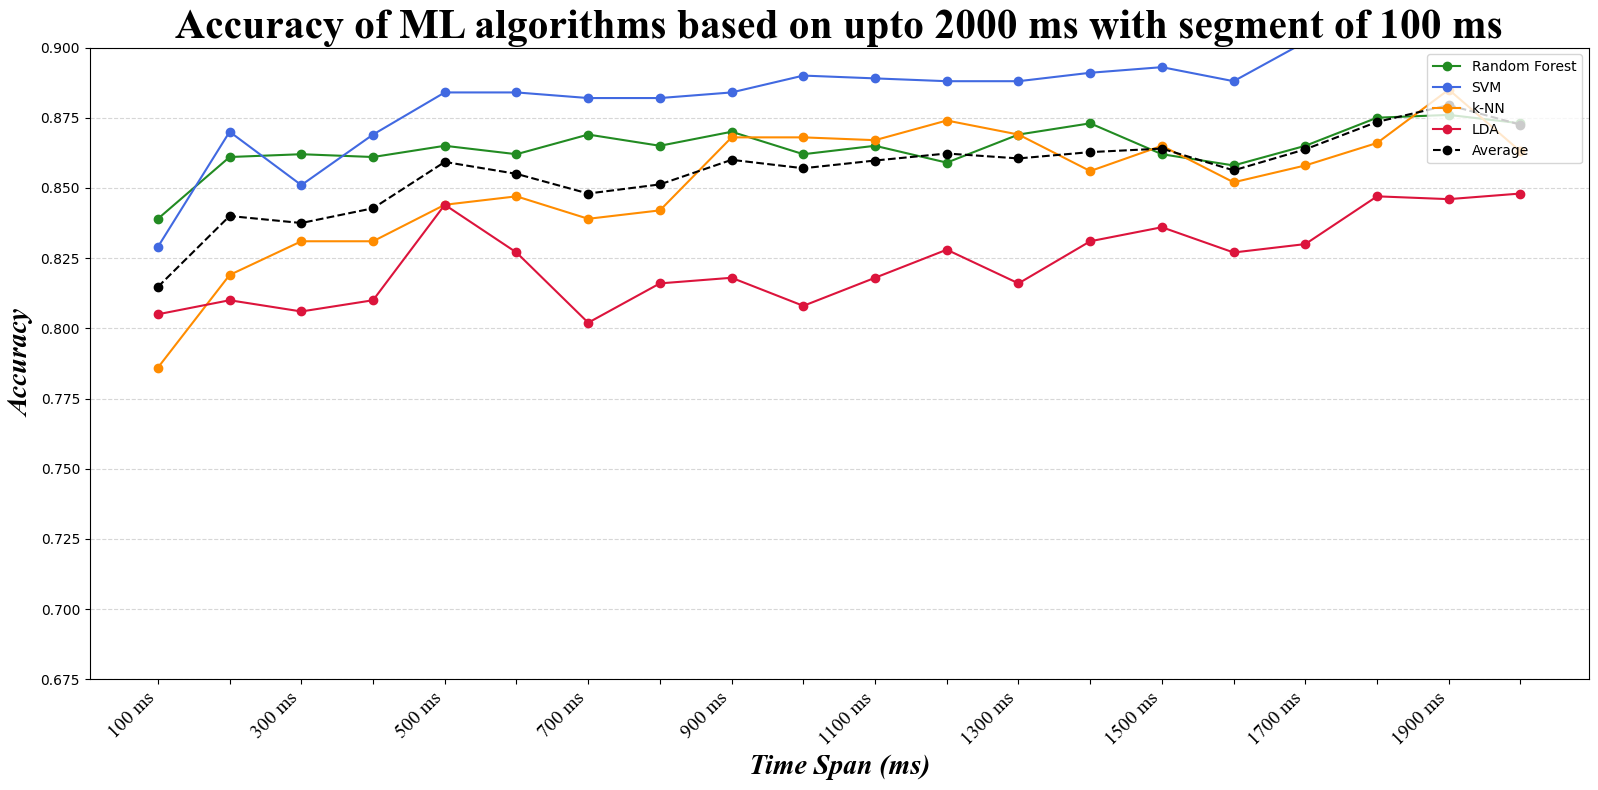

In [ ]:
records = []
sd = seedList[0]
print(f"seed number: {sd}")
random.seed(sd)
np.random.seed(sd)
filt = True

for end_point in range(SEGMENT_LENGTH, END_POINT + 1, SEGMENT_LENGTH):
    print(f"\n\nSEGMENT LENGTH: {end_point} ms")
    results = pipe(filenames, 
                    end_point=end_point, 
                    segment_length=end_point, 
                    dwt_filt=filt,
                    apply_filter=filt, 
                    initializer=True, 
                    model_commands=["all"],
                    model_seedloop="avg",
                    SEED=sd,
                    seed_list=seedList,
                    feature_seedloop="single",
                    num_top_features=40
                    )
    
    # Build readable label from segment range
    start_ms = end_point - end_point
    end_ms = end_point
    label = f"{end_point} ms"
    
    loop_acc = {'Range': label}  # extra column with your heading
    
    for name, ress in results.items():
        loop_acc[name] = round(ress['accuracy'], 3)
    
    records.append(loop_acc)

result_df = pd.DataFrame(records)
result_df.to_excel(f"Classification based on upto {end_point} ms with segment of {SEGMENT_LENGTH} ms filter {filt} k-fold cross validation.xlsx", index=False)
plot(result_df, segment=False, plot_type='line', type='pdf')


temporal moving window analysis

Window length: 400


WINDOW RANGE: (0 - 400) ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((0 - 400) SAMPLES):
Random Forest: Accuracy = 0.861
SVM: Accuracy = 0.869
k-NN: Accuracy = 0.831
LDA: Accuracy = 0.810


WINDOW RANGE: (100 - 500) ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((100 - 500) SAMPLES):
Random Forest: Accuracy = 0.865
SVM: Accuracy = 0.869
k-NN: Accuracy = 0.834
LDA: Accuracy = 0.834


WINDOW RANGE: (200 - 600) ms

Performing stratified k-fold cross-validation with 9 folds...

Selecting top 40 features using single seed 1...

Running multiple seeds for robustness of the models...

FINAL RESULTS ((200 - 600) SAMPLES):
Random Forest: Accuracy = 0.855
SVM: Accuracy = 0.877
k-NN: Accuracy = 0.

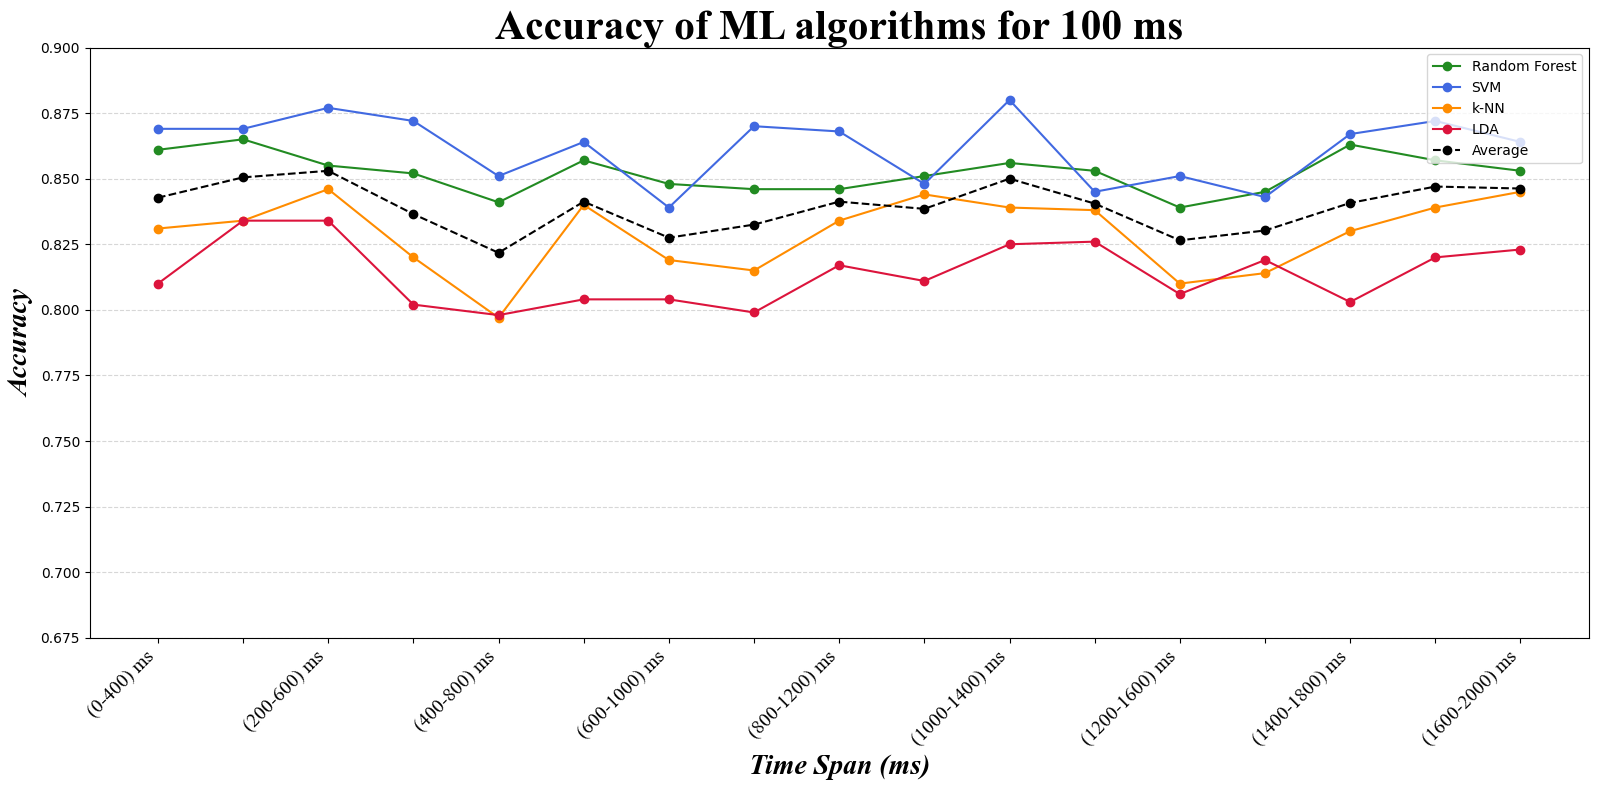

In [ ]:
records = []
window_len = 400
step_size = 100

print(f"Window length: {window_len}")

for end_point in range(window_len, 
                       END_POINT + 1,
                       step_size 
                       ):
    print(f"\n\nWINDOW RANGE: ({end_point - window_len} - {end_point}) ms")
    results = pipe(filenames, 
                    end_point=end_point, 
                    dwt_filt=filt,
                    apply_filter=filt, 
                    segment_length=window_len, 
                    initializer=False, 
                    model_commands=["all"],
                    model_seedloop="avg",
                    SEED=sd,
                    seed_list=seedList,
                    feature_seedloop="single",
                    num_top_features=40
                    )
    
    # Build readable label from segment range
    start_ms = end_point - window_len
    end_ms = end_point
    label = f"({start_ms}-{end_ms}) ms"
    
    loop_acc = {'Range': label}  # extra column with your heading
    
    for name, ress in results.items():
        loop_acc[name] = round(ress['accuracy'], 3)
    
    records.append(loop_acc)

# DataFrame will have 'Range' as the leftmost column
result_df = pd.DataFrame(records)
result_df.to_excel(f"Segment_wise_classification (step size={step_size} ms) filter {filt} k-fold cross validation.xlsx", index=False)
plot(result_df, segment=True, plot_type='line', type='pdf')


## Leave One Subject Out Cross (LOSO) Validation

Cumulative temporal analysis

seed number: 1


SEGMENT LENGTH: 100 ms

Performing leave one subject out cross-validation...

Running multiple seeds for robustness of the models...

Selected top 40 features using single seed 1...

-- Subject 1 held out for testing --
-- Subject 2 held out for testing --
-- Subject 3 held out for testing --
-- Subject 4 held out for testing --
-- Subject 5 held out for testing --
-- Subject 6 held out for testing --
-- Subject 7 held out for testing --
-- Subject 8 held out for testing --
-- Subject 9 held out for testing --
-- Subject 10 held out for testing --
-- Subject 11 held out for testing --
-- Subject 12 held out for testing --
-- Subject 13 held out for testing --
-- Subject 14 held out for testing --
-- Subject 15 held out for testing --
-- Subject 16 held out for testing --
-- Subject 17 held out for testing --
-- Subject 18 held out for testing --
-- Subject 19 held out for testing --
-- Subject 20 held out for testing --
-- Subject 21 held out for testing --
-- Subject 

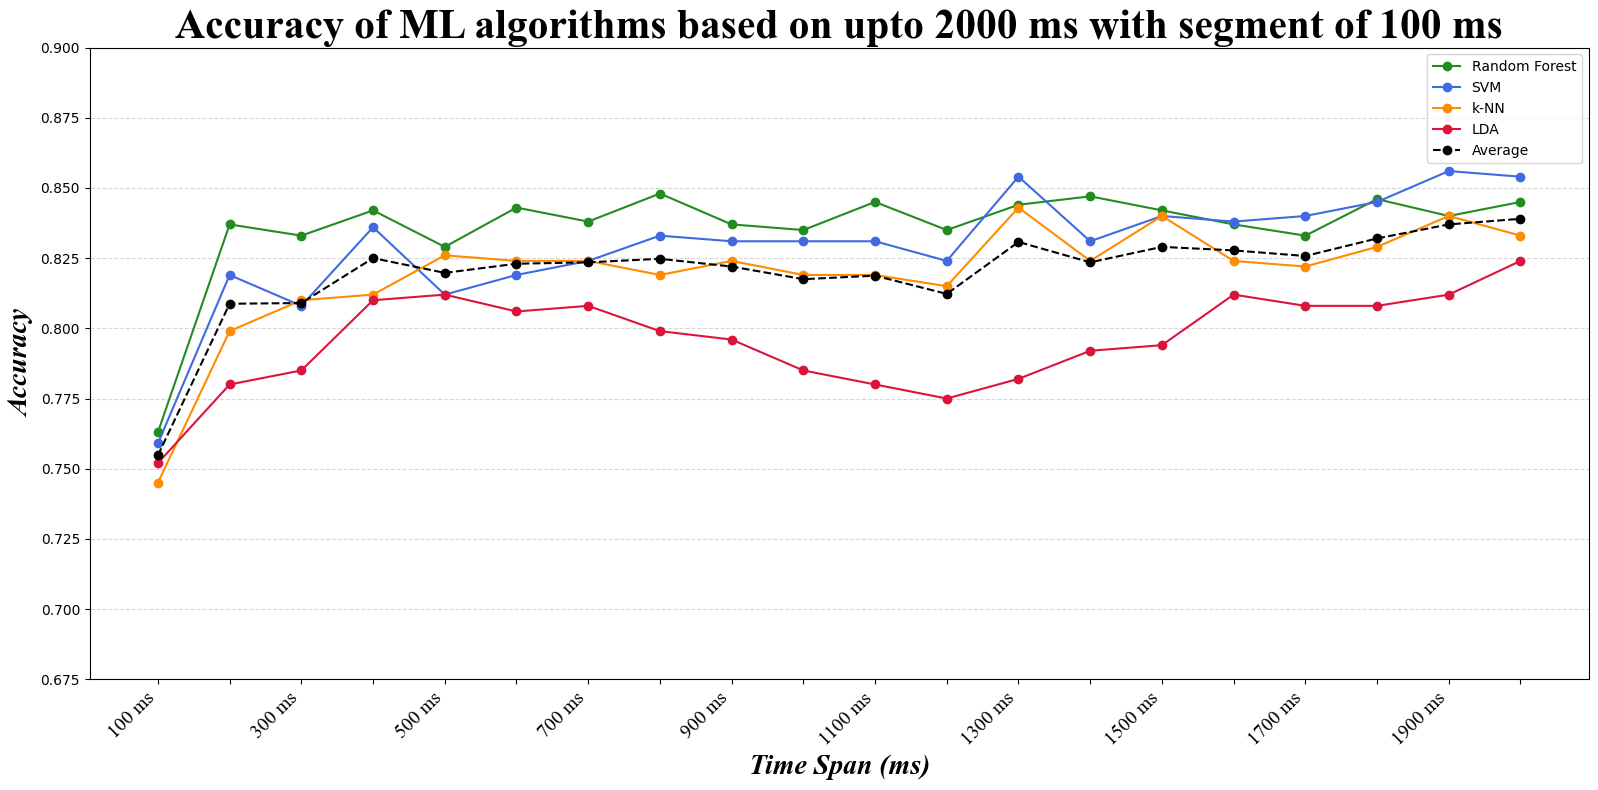

In [ ]:
records = []
sd = seedList[0]
print(f"seed number: {sd}")
random.seed(sd)
np.random.seed(sd)
filt = True

for end_point in range(SEGMENT_LENGTH, END_POINT + 1, SEGMENT_LENGTH):
    print(f"\n\nSEGMENT LENGTH: {end_point} ms")
    results = pipe2(filenames, 
                    end_point=end_point, 
                    segment_length=end_point, 
                    dwt_filt=filt,
                    apply_filter=filt, 
                    initializer=True, 
                    model_commands=["all"],
                    model_seedloop="avg",
                    SEED=sd,
                    seed_list=seedList,
                    feature_seedloop="single",
                    num_top_features=40
                    )
    
    # Build readable label from segment range
    start_ms = end_point - end_point
    end_ms = end_point
    label = f"{end_point} ms"
    
    loop_acc = {'Range': label}  # extra column with your heading
    
    for name, ress in results.items():
        loop_acc[name] = round(ress['accuracy'], 3)
    
    records.append(loop_acc)

result_df = pd.DataFrame(records)
result_df.to_excel(f"Classification based on upto {end_point} ms with segment of {SEGMENT_LENGTH} ms filter {filt} sub-cross validation.xlsx", index=False)
plot(result_df, segment=False, plot_type='line', type='pdf')


temporal moving window analysis

Window length: 400


WINDOW RANGE: (0 - 400) ms

Performing leave one subject out cross-validation...

Running multiple seeds for robustness of the models...

Selected top 40 features using single seed 1...

-- Subject 01 held out for testing --
-- Subject 02 held out for testing --
-- Subject 03 held out for testing --
-- Subject 04 held out for testing --
-- Subject 05 held out for testing --
-- Subject 06 held out for testing --
-- Subject 07 held out for testing --
-- Subject 08 held out for testing --
-- Subject 09 held out for testing --
-- Subject 10 held out for testing --
-- Subject 11 held out for testing --
-- Subject 12 held out for testing --
-- Subject 13 held out for testing --
-- Subject 14 held out for testing --
-- Subject 15 held out for testing --
-- Subject 16 held out for testing --
-- Subject 17 held out for testing --
-- Subject 18 held out for testing --
-- Subject 19 held out for testing --
-- Subject 20 held out for testing --
-- Subject 21 held out for testi

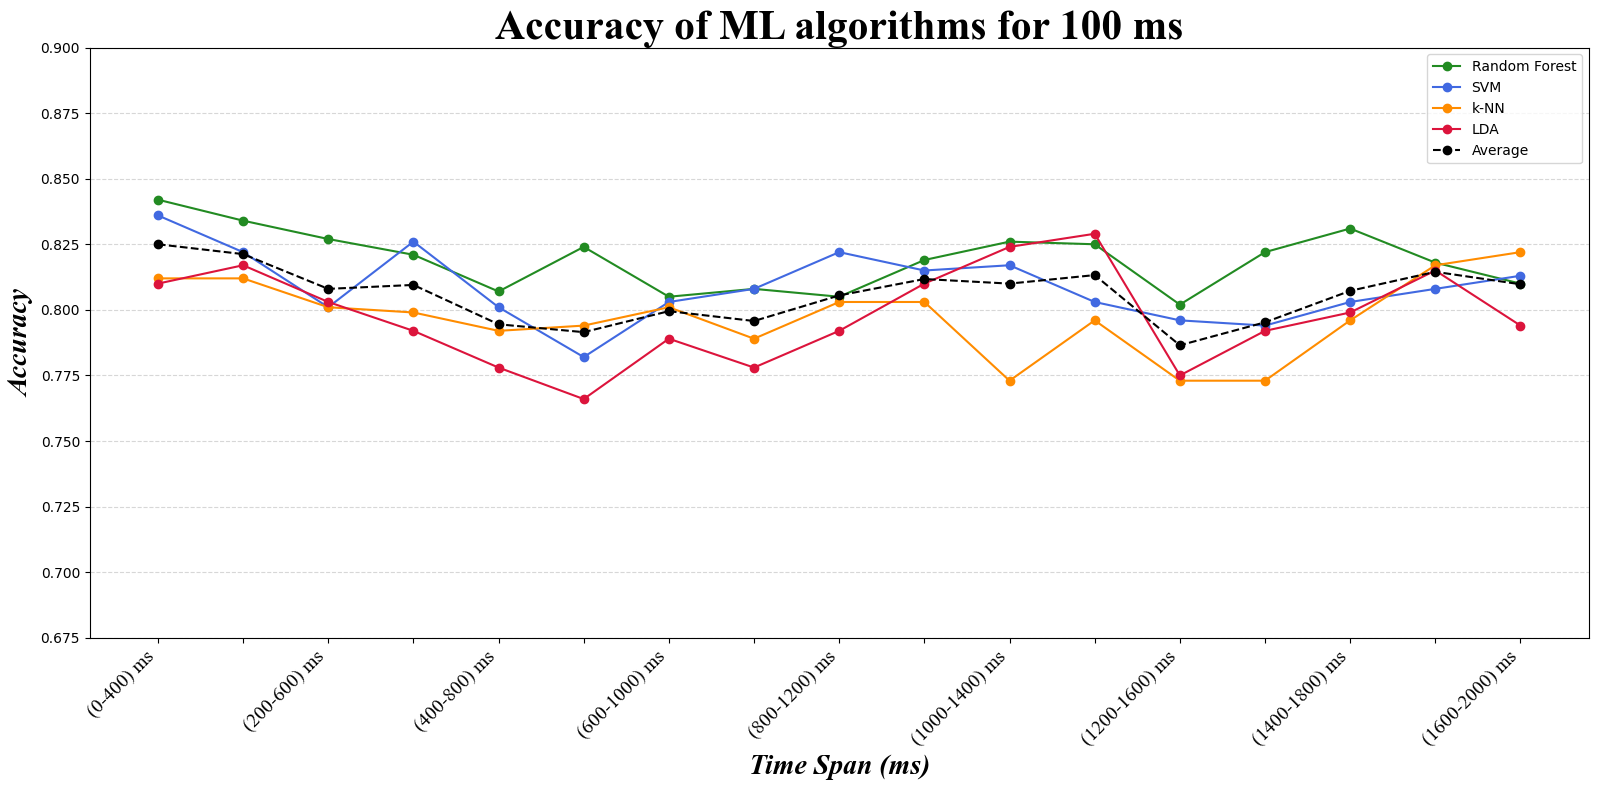

In [ ]:
records = []
window_len = 400
step_size = 100

print(f"Window length: {window_len}")

for end_point in range(window_len, 
                       END_POINT + 1,
                       step_size 
                       ):
    print(f"\n\nWINDOW RANGE: ({end_point - window_len} - {end_point}) ms")
    results = pipe2(filenames, 
                    end_point=end_point, 
                    dwt_filt=filt,
                    apply_filter=filt, 
                    segment_length=window_len, 
                    initializer=False, 
                    model_commands=["all"],
                    model_seedloop="avg",
                    SEED=sd,
                    seed_list=seedList,
                    feature_seedloop="single",
                    num_top_features=40
                    )
    
    # Build readable label from segment range
    start_ms = end_point - window_len
    end_ms = end_point
    label = f"({start_ms}-{end_ms}) ms"
    
    loop_acc = {'Range': label}  # extra column with your heading
    
    for name, ress in results.items():
        loop_acc[name] = round(ress['accuracy'], 3)
    
    records.append(loop_acc)

result_df = pd.DataFrame(records)
result_df.to_excel(f"Segment_wise_classification (step size={step_size} ms) filter {filt} sub-cross validation.xlsx", index=False)
plot(result_df, segment=True, plot_type='line', type='pdf')
